In [1]:
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torchvision import transforms
from PIL import Image
import gzip
%matplotlib inline

In [2]:
# 加载数据
def load_data(data_file):
    files = ['train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz']
    paths = []
    for fileName in files:
        paths.append(os.path.join(data_file, fileName))
        
    # 读取每个文件夹的数据    
    with gzip.open(paths[0], 'rb') as train_labels_path:   # rb 以2进制格式打开
        train_labels = np.frombuffer(train_labels_path.read(), np.uint8, offset=8)
      
    with gzip.open(paths[1], 'rb') as train_images_path:
        train_images = np.frombuffer(train_images_path.read(), np.uint8, offset=16).reshape(len(train_labels), 784)
       
    with gzip.open(paths[2], 'rb') as test_labels_path:
        test_labels = np.frombuffer(test_labels_path.read(), np.uint8, offset=8)
        
    with gzip.open(paths[3], 'rb') as test_images_path:
        test_images = np.frombuffer(test_images_path.read(), np.uint8, offset=16).reshape(len(test_labels), 784)
        
    return train_labels,train_images,test_labels,test_images
 
train_labels,train_images,test_labels,test_images = load_data('C:\\Users\\Fan\\JupyterFile\\data\\MNIST\\raw\\')
print(train_labels.shape)
print(train_images.shape)
print(test_labels.shape)
print(test_images.shape)

# 创建加载器
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        image = self.images[idx].reshape(28,28)
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        #label = 1 if self.labels[idx] >=5 else 0
        return image,label
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 64

train_dataset = ImageDataset(images = train_images, labels = train_labels, transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = ImageDataset(images = test_images, labels = test_labels, transform = transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

(60000,)
(60000, 784)
(10000,)
(10000, 784)


In [3]:
def show_image(tensor):
    tensor=torch.clamp(tensor,0,1)
    tensor = tensor.detach().squeeze().numpy()
    plt.imshow(tensor)
    plt.axis('off')  # 关闭坐标轴
    plt.show()
def show_images_all(imgs):
    n = imgs.size(0)  # 获取图片数量
    rows = int(np.sqrt(n))  # 确定方形图中行数和列数
    cols = n // rows
    
    # 创建一个新的图像
    fig, axs = plt.subplots(rows, cols, figsize=(8, 8))
    axs = axs.flatten()
    
    for i in range(n):
        img = imgs[i].detach().numpy()
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')  # 关闭坐标轴
    
    plt.tight_layout()
    plt.show()

In [4]:
# 模型定义
# 初始化权重函数
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:   # 没有则返回-1，有则返回0
        nn.init.normal_(m.weight.data, 0.0, 0.02)    # 使用正态分布初始化权重数据，均值0，标准差0.02
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)    # 使用正态分布初始化权重数据，均值1，标准差0.02
        nn.init.constant_(m.bias.data, 0)     # 使用常数初始化偏置项数据
        
# 生成器
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100,1024)
        self.fc2 = nn.Linear(1024,6272)
        self.up1 = nn.ConvTranspose2d(in_channels=128,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False)
        self.conv1 = nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.up2 = nn.ConvTranspose2d(in_channels=64,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False)
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=1,kernel_size=3,stride=1,padding=1)

    def forward(self, x):
        x = nn.functional.leaky_relu(self.fc1(x))
        x = nn.functional.leaky_relu(self.fc2(x))
        x = x.view(-1,128,7,7)
        x = self.up1(x)
        x = nn.functional.relu(self.conv1(x))
        x = self.up2(x)
        x = torch.tanh(self.conv2(x))

        return x.squeeze()

'''class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 1024)
        self.fc2 = nn.Linear(1024, 6272)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)
    
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = x.view(-1, 128, 7, 7)
        x = self.upsample(x)
        x = nn.functional.relu(self.conv1(x))
        x = self.upsample(x)
        x = self.conv2(x)
        x = torch.tanh(x)
        
        return x.squeeze()'''
    
# 判别器
'''class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
        self.fc1 = nn.Linear(128*5*5,1024)
        self.fc2 = nn.Linear(1024,1)
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1,128*5*5)
        x = nn.functional.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        
        return x'''

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,256)
        self.fc4 = nn.Linear(256,1)
        self.drop = nn.Dropout2d(p=0.3)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = nn.functional.leaky_relu(self.fc1(x))
        x = self.drop(x)
        x = nn.functional.leaky_relu(self.fc2(x))
        x = self.drop(x)
        x = nn.functional.leaky_relu(self.fc3(x))
        x = self.drop(x)
        x = torch.sigmoid(self.fc4(x))
        
        return x

E:\anaconda3\lib\site-packages\torchvision\transforms\functional.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:205.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
E:\anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and a

[Epoch 1/10] [Batch 1/938] [D loss: 0.6982629299163818] [G loss: 0.6879948973655701]


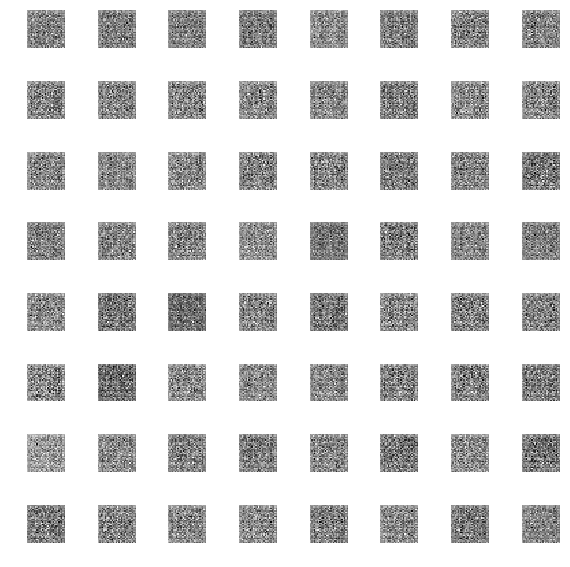

[Epoch 1/10] [Batch 101/938] [D loss: 0.0003415004466660321] [G loss: 9.23260498046875]


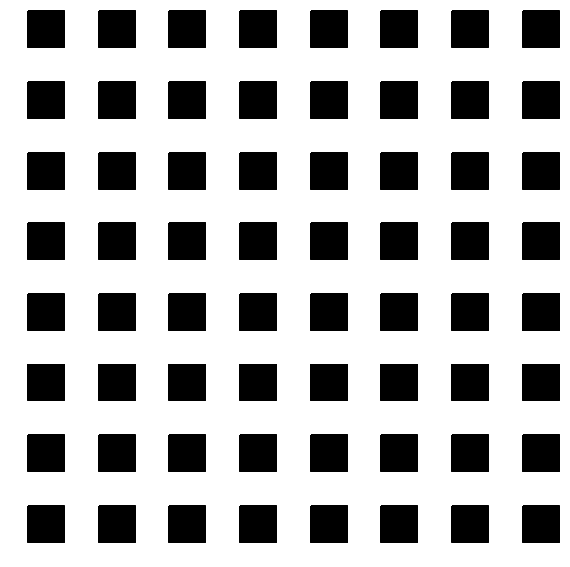

[Epoch 1/10] [Batch 201/938] [D loss: 0.00013438409951049834] [G loss: 9.621119499206543]


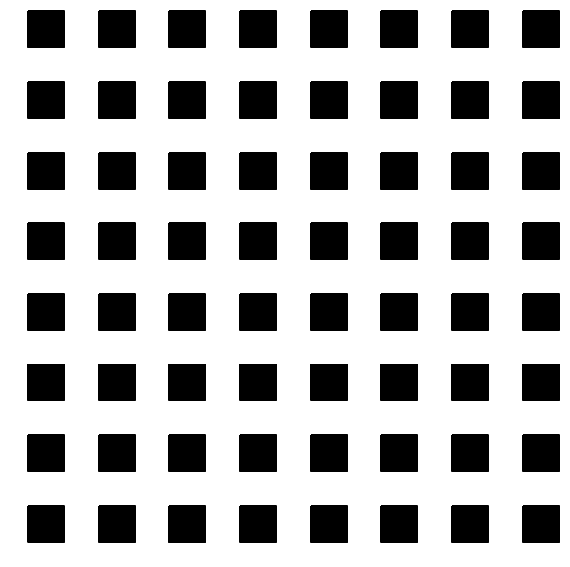

[Epoch 1/10] [Batch 301/938] [D loss: 0.0007145412382669747] [G loss: 13.995808601379395]


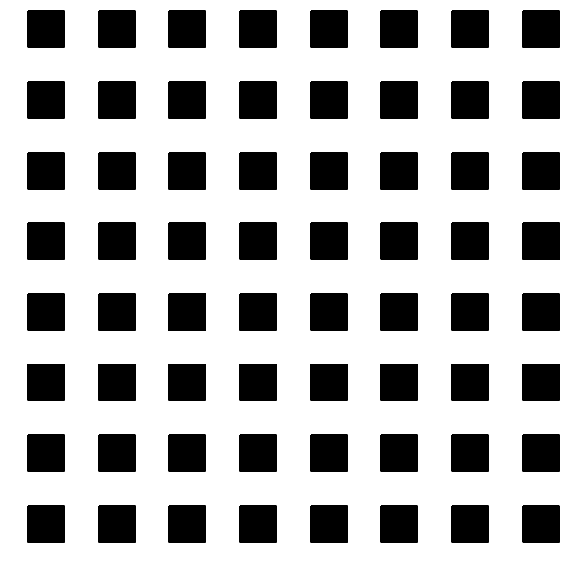

[Epoch 1/10] [Batch 401/938] [D loss: 2.4702210794202983e-05] [G loss: 12.053709983825684]


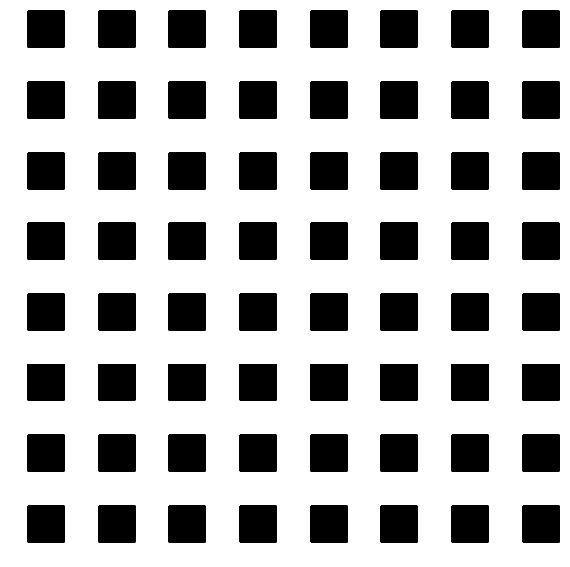

[Epoch 1/10] [Batch 501/938] [D loss: 4.1645849705673754e-05] [G loss: 10.706558227539062]


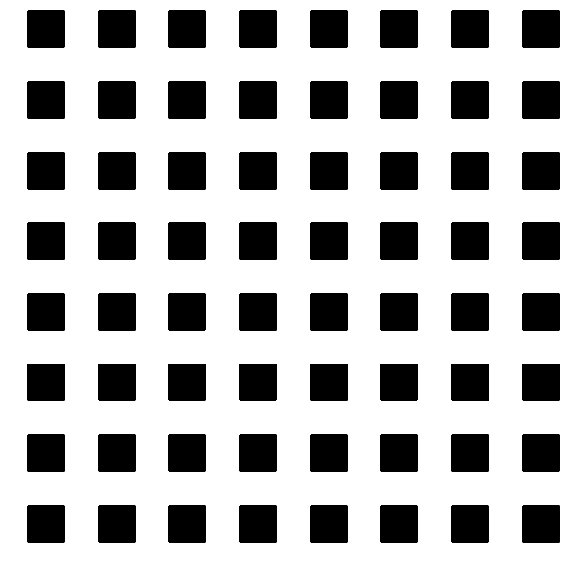

[Epoch 1/10] [Batch 601/938] [D loss: 0.00011496598017401993] [G loss: 12.9857816696167]


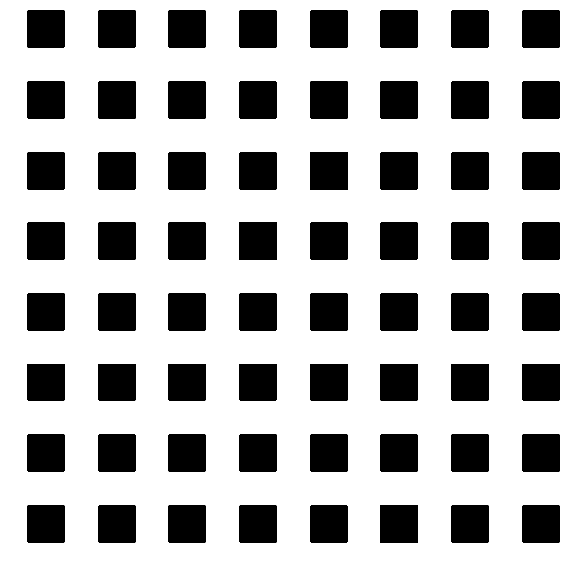

[Epoch 1/10] [Batch 701/938] [D loss: 1.5115781025087927e-05] [G loss: 11.762296676635742]


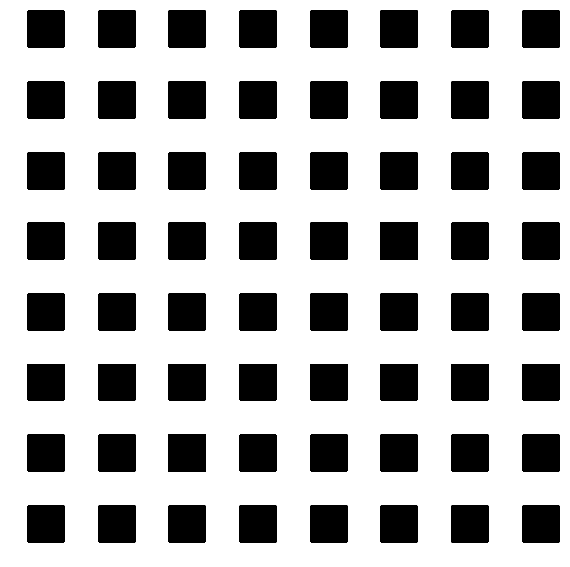

[Epoch 1/10] [Batch 801/938] [D loss: 1.1335550880176015e-05] [G loss: 12.343189239501953]


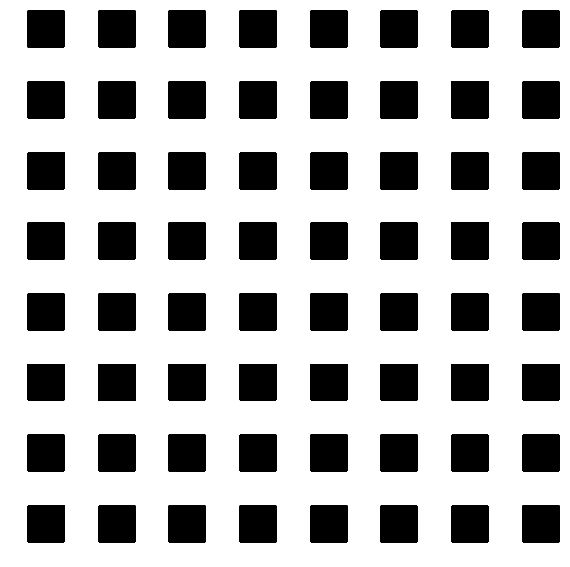

[Epoch 1/10] [Batch 901/938] [D loss: 0.001289639505557716] [G loss: 5.539151191711426]


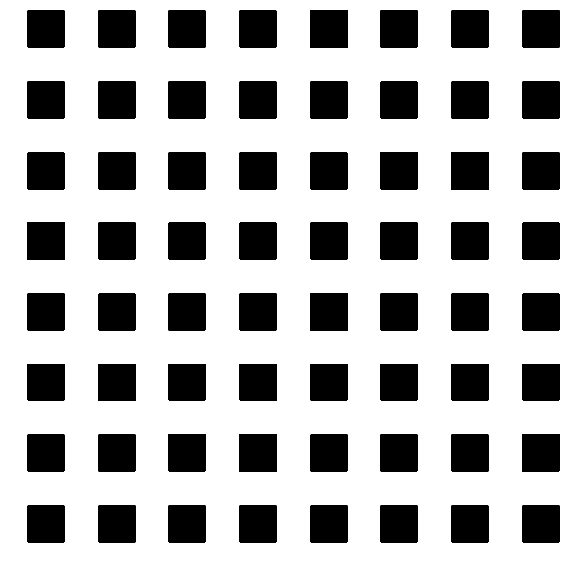

[Epoch 2/10] [Batch 1/938] [D loss: 0.0006686579436063766] [G loss: 8.637392044067383]


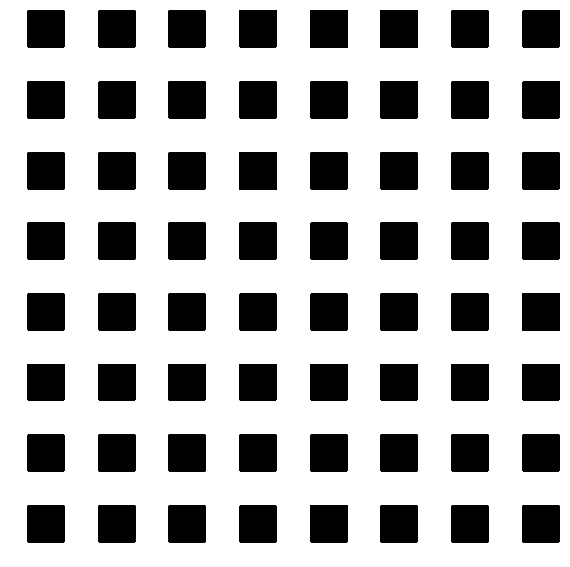

[Epoch 2/10] [Batch 101/938] [D loss: 1.2584887372213416e-05] [G loss: 15.798663139343262]


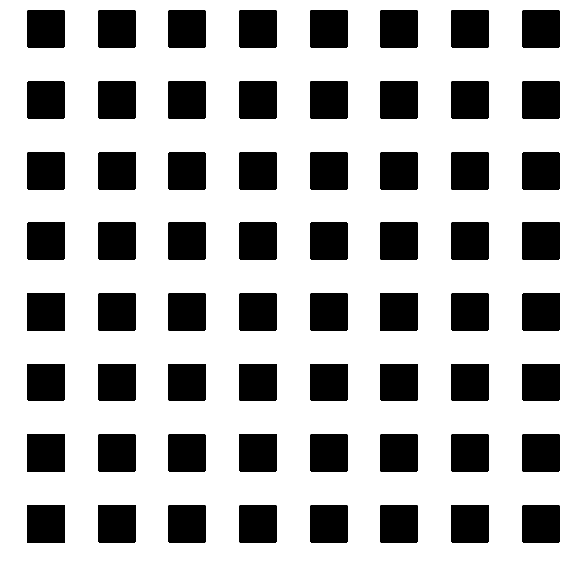

[Epoch 2/10] [Batch 201/938] [D loss: 3.4944771414302522e-06] [G loss: 14.262653350830078]


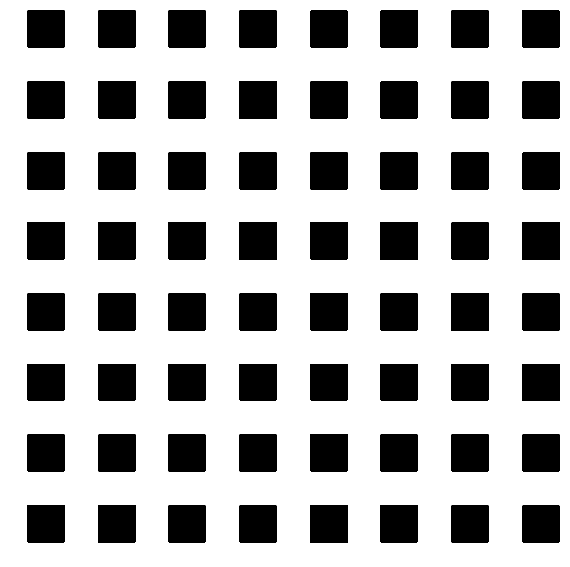

[Epoch 2/10] [Batch 301/938] [D loss: 6.271419351833174e-06] [G loss: 13.634658813476562]


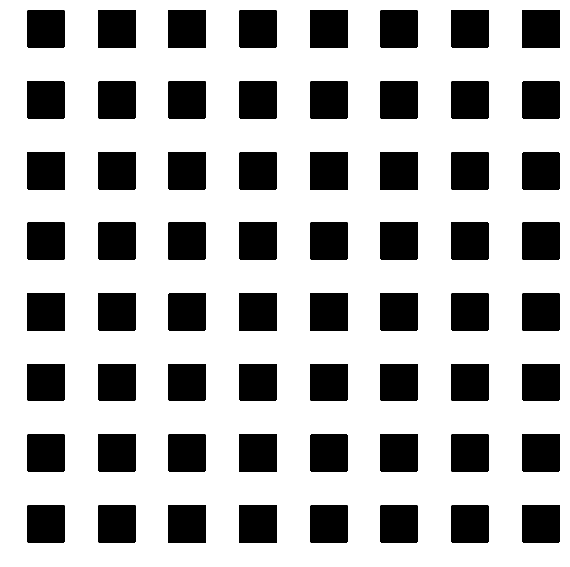

[Epoch 2/10] [Batch 401/938] [D loss: 2.5863212158583337e-06] [G loss: 14.47531509399414]


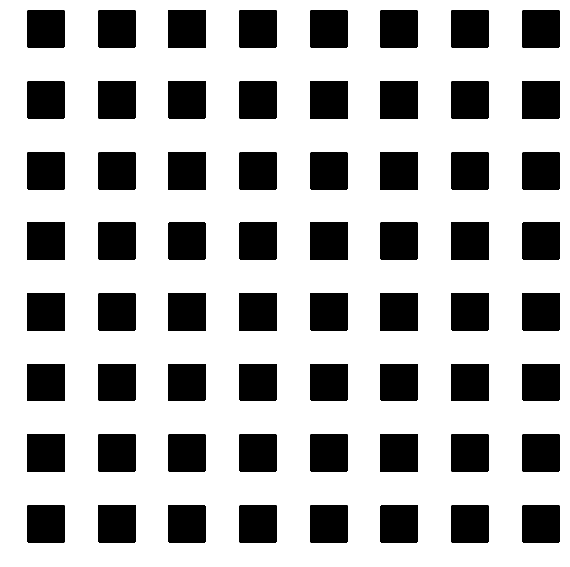

[Epoch 2/10] [Batch 501/938] [D loss: 3.197867044946179e-06] [G loss: 14.098159790039062]


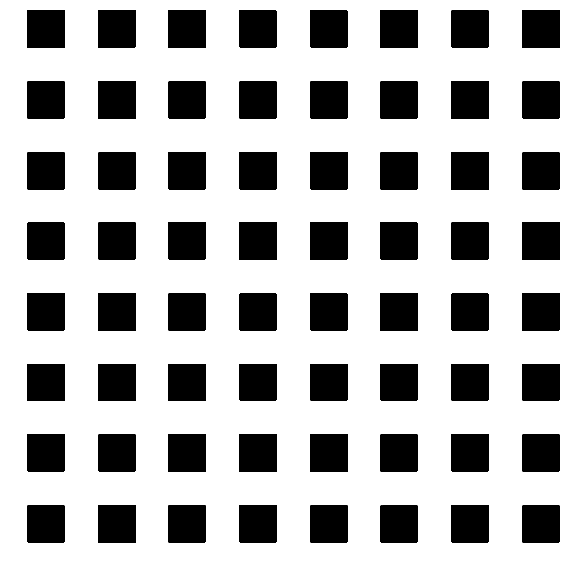

[Epoch 2/10] [Batch 601/938] [D loss: 2.7935511752730235e-06] [G loss: 14.777888298034668]


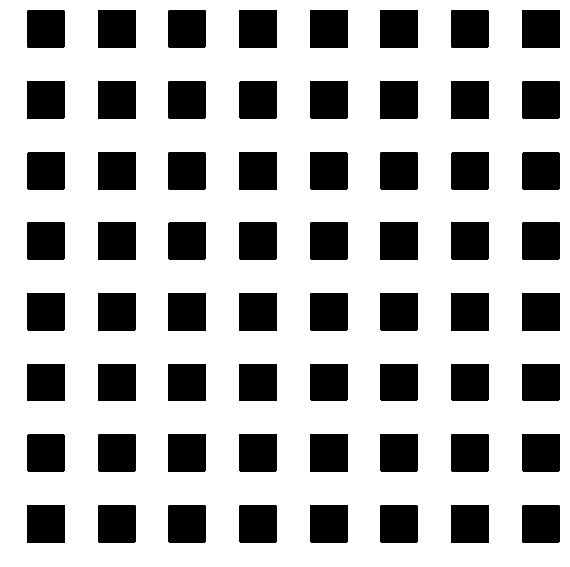

[Epoch 2/10] [Batch 701/938] [D loss: 1.868261620074918e-06] [G loss: 16.359689712524414]


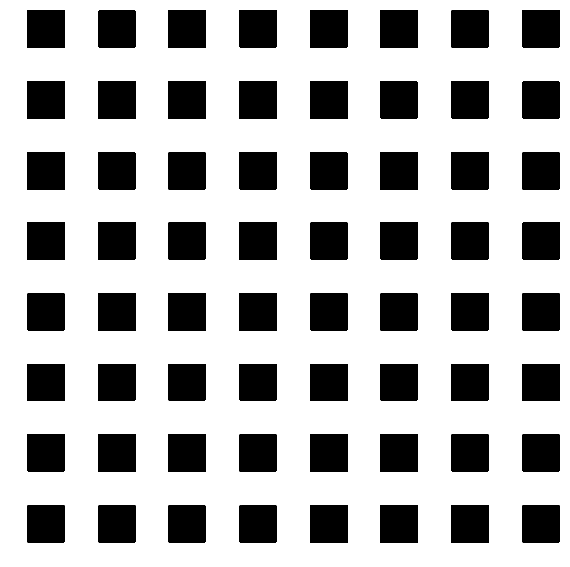

[Epoch 2/10] [Batch 801/938] [D loss: 2.658646280906396e-06] [G loss: 16.12506103515625]


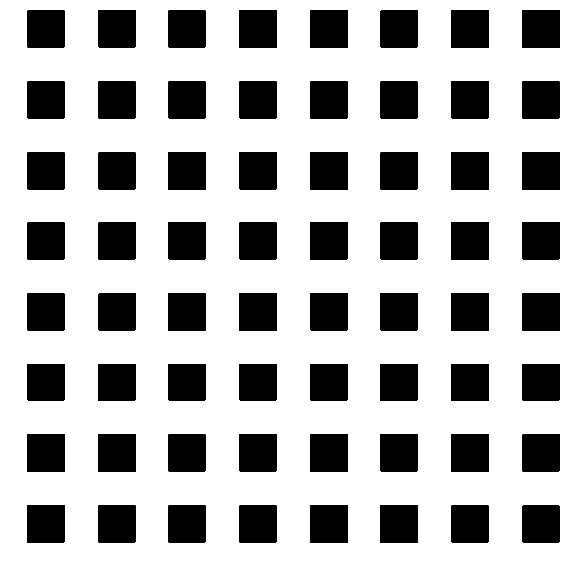

[Epoch 2/10] [Batch 901/938] [D loss: 2.76137910759644e-07] [G loss: 16.33727264404297]


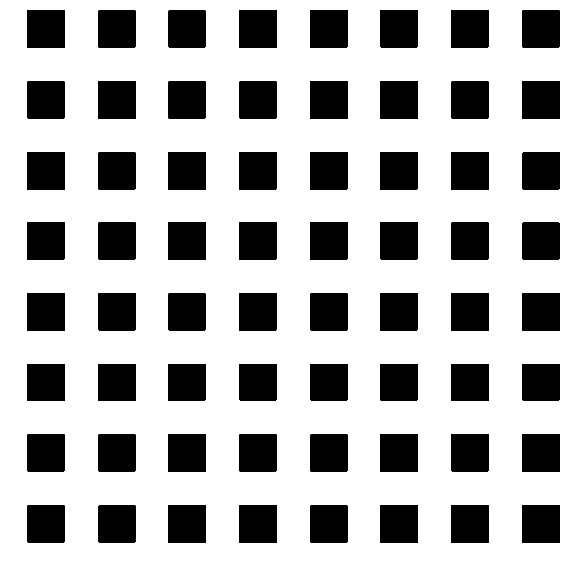

[Epoch 3/10] [Batch 1/938] [D loss: 3.7822755984961987e-06] [G loss: 15.228184700012207]


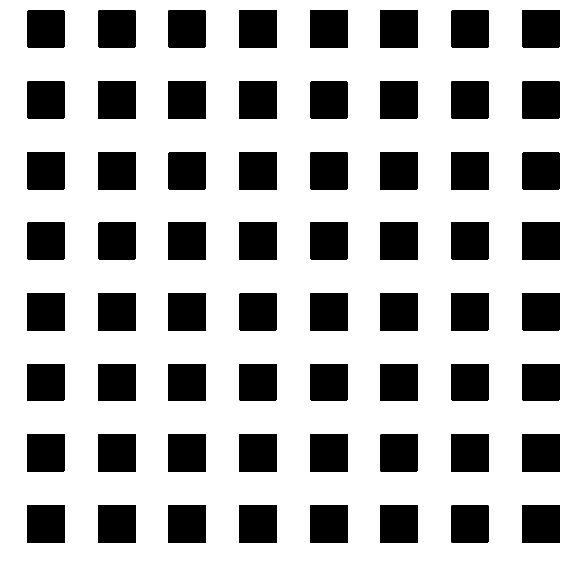

[Epoch 3/10] [Batch 101/938] [D loss: 1.6639411342111998e-06] [G loss: 18.78736114501953]


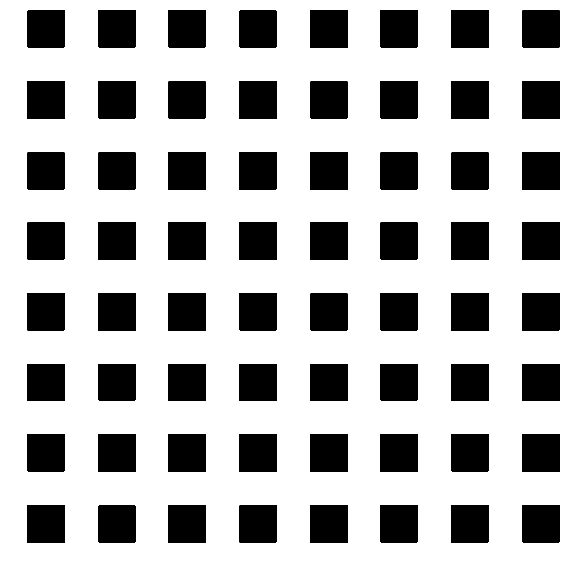

[Epoch 3/10] [Batch 201/938] [D loss: 1.1506645023473538e-06] [G loss: 15.979818344116211]


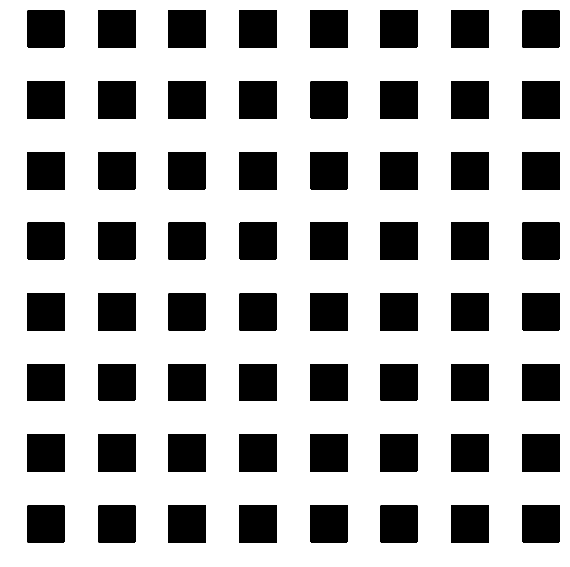

[Epoch 3/10] [Batch 301/938] [D loss: 2.1932677896074892e-07] [G loss: 16.735912322998047]


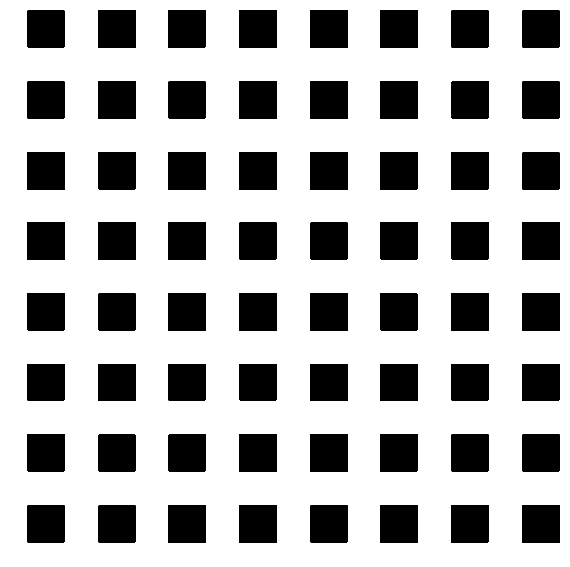

[Epoch 3/10] [Batch 401/938] [D loss: 4.0233464915218065e-07] [G loss: 17.599367141723633]


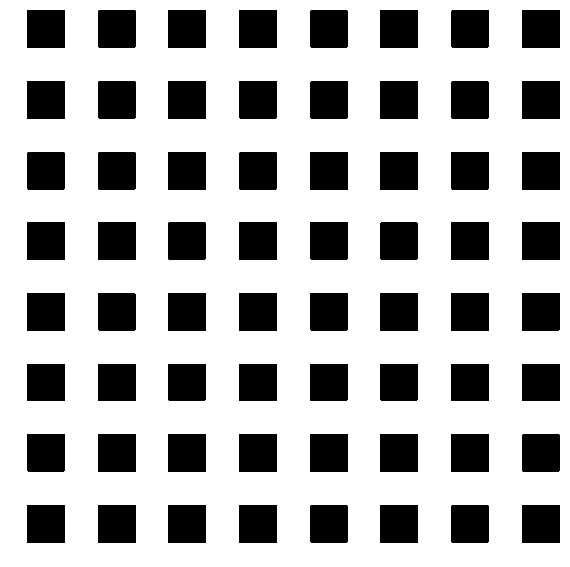

[Epoch 3/10] [Batch 501/938] [D loss: 0.00017747125821188092] [G loss: 21.65032196044922]


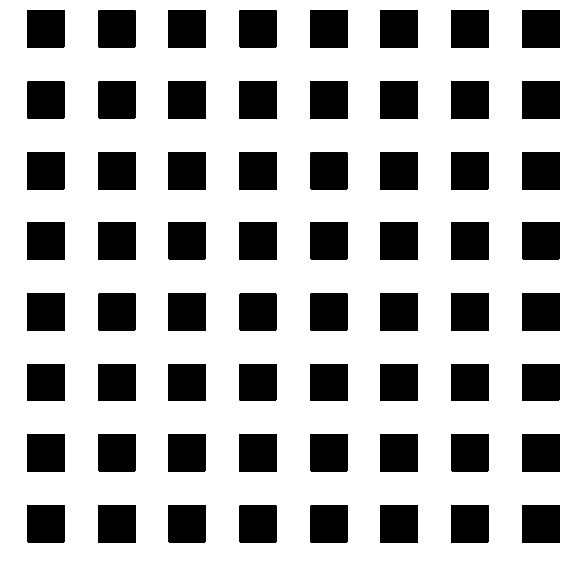

[Epoch 3/10] [Batch 601/938] [D loss: 4.516113222052809e-06] [G loss: 14.45899486541748]


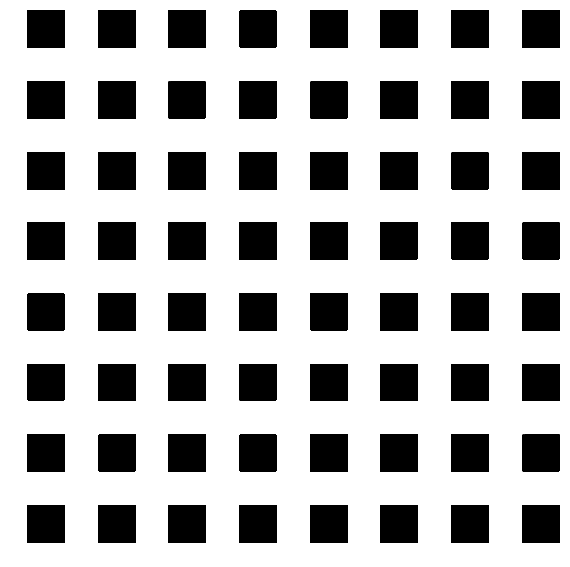

[Epoch 3/10] [Batch 701/938] [D loss: 6.868543778182357e-07] [G loss: 17.241851806640625]


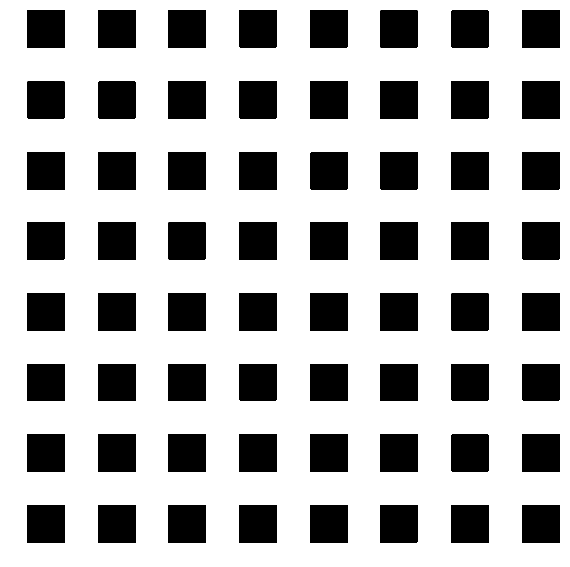

[Epoch 3/10] [Batch 801/938] [D loss: 2.1928642581769964e-06] [G loss: 17.749813079833984]


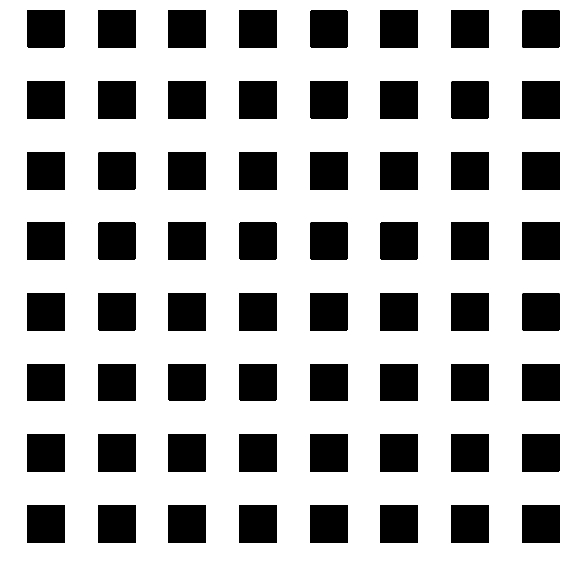

[Epoch 3/10] [Batch 901/938] [D loss: 2.0248953660484403e-06] [G loss: 18.219411849975586]


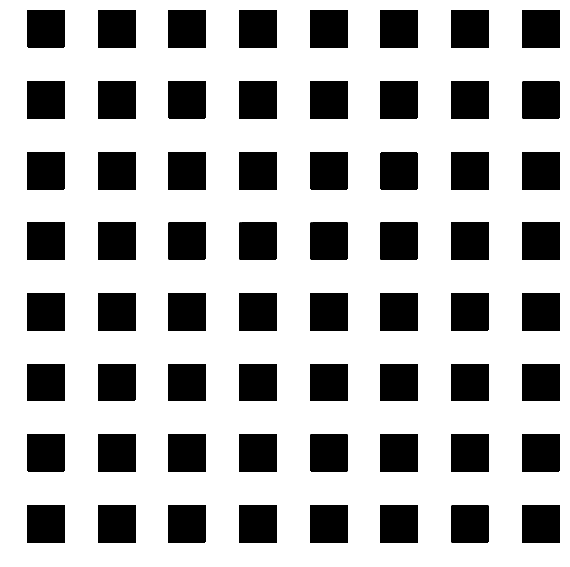

[Epoch 4/10] [Batch 1/938] [D loss: 2.780004138003278e-07] [G loss: 18.26956558227539]


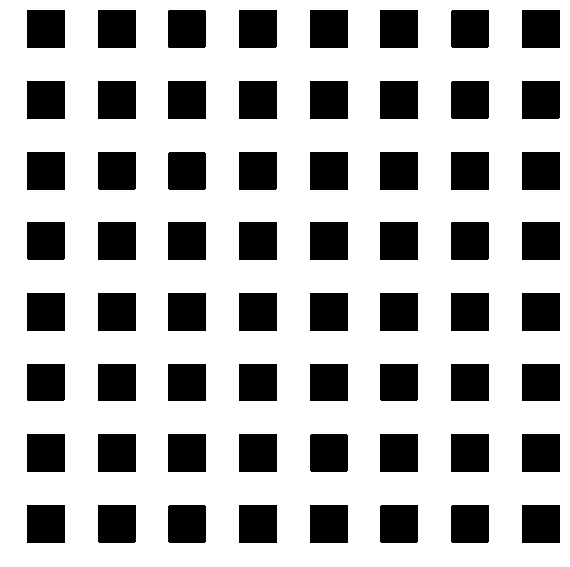

[Epoch 4/10] [Batch 101/938] [D loss: 5.872061592526734e-07] [G loss: 18.505695343017578]


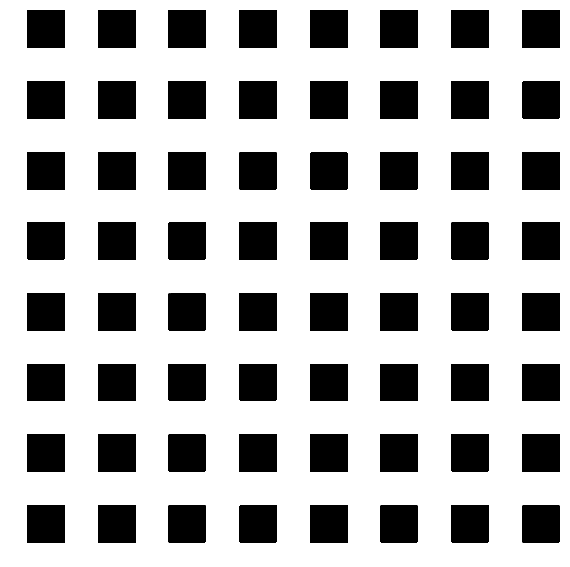

[Epoch 4/10] [Batch 201/938] [D loss: 4.5169525719757075e-07] [G loss: 18.990402221679688]


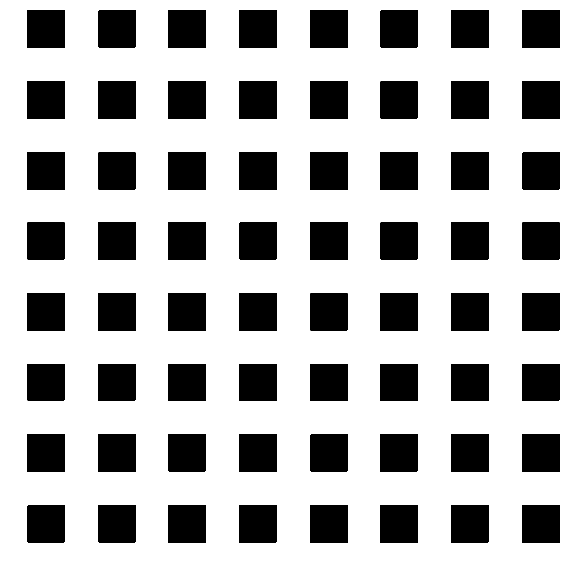

[Epoch 4/10] [Batch 301/938] [D loss: 1.5735628267066204e-06] [G loss: 16.889568328857422]


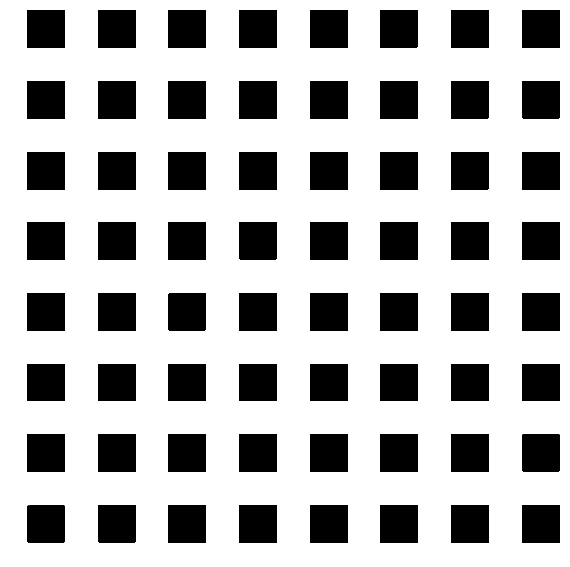

[Epoch 4/10] [Batch 401/938] [D loss: 3.147068355247029e-06] [G loss: 14.701780319213867]


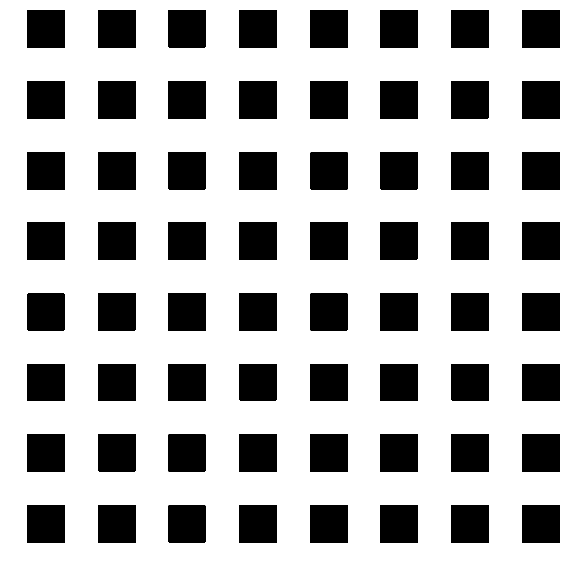

[Epoch 4/10] [Batch 501/938] [D loss: 1.9436997718003113e-06] [G loss: 15.266725540161133]


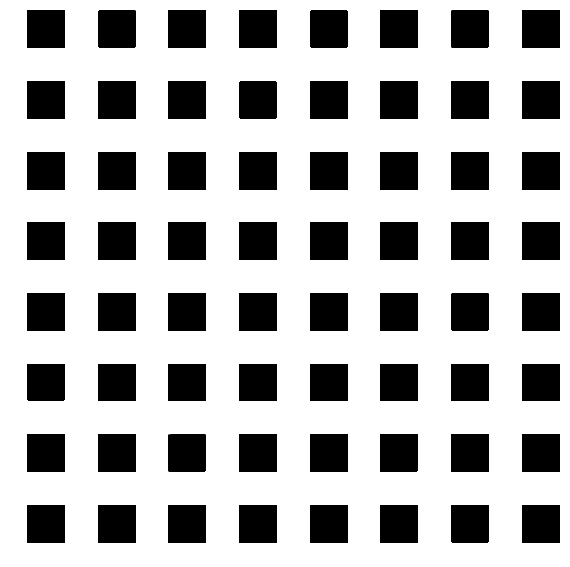

In [ ]:
# 创建生成器和鉴别器
netG = Generator()
netD = Discriminator()

# 应用权重初始化
netG.apply(weights_init)
netD.apply(weights_init)

manual_seed = 886
torch.manual_seed(manual_seed)

beta1 = 0.5
lr = 0.0002
# 定义损失函数和优化器
criterion = nn.BCELoss()     # 无法使用？
#criterion = nn.CrossEntropyLoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr)

DLoss=[]
GLoss=[]
# 模型训练
epochs = 10
for epoch in range(epochs):
    for i, (real_images,_) in enumerate(train_loader):
        train_size = real_images.shape[0]
        real_labels = torch.ones(train_size, 1)
        fake_labels = torch.zeros(train_size, 1)
        # 生成假图
        z = torch.randn(train_size, 100)
        fake_images = netG(z)
        
        # 更新鉴别器D
        netD.zero_grad()
        d_real = netD(real_images)
        d_real_loss = criterion(d_real, real_labels)

        d_fake = netD(fake_images)
        d_fake_loss = criterion(d_fake, fake_labels)
        d_real_loss.backward()
        d_fake_loss.backward()
        d_loss = (d_real_loss + d_fake_loss) / 2
        optimizerD.step()
        DLoss.append(d_loss)
        
        # 更新生成器G
        netG.zero_grad()
        fake_images = netG(z)
        d_fake = netD(fake_images)
        g_loss = criterion(d_fake, real_labels)
        g_loss.backward()
        optimizerG.step()
        GLoss.append(g_loss)
        
        if i % 100 == 0:
            print(f"[Epoch {epoch+1}/{epochs}] [Batch {i+1}/{len(train_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")
            show_images_all(fake_images)

In [1]:
plt.figure(figsize=(10, 5))
plt.plot(DLoss, label='D Loss')
plt.plot(GLoss, label='G Loss')
plt.show()

NameError: name 'plt' is not defined